<a href="https://colab.research.google.com/github/emaroppo/phish-gen/blob/master/Phish_Gen_GPT2_Training_%26_Inferrence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install transformers tokenizers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.4 MB/s 
     |████████████████████████████████| 7.6 MB 67.9 MB/s 
     |████████████████████████████████| 451 kB 86.7 MB/s 
     |████████████████████████████████| 182 kB 84.8 MB/s 
     |████████████████████████████████| 212 kB 92.4 MB/s 
     |████████████████████████████████| 132 kB 67.6 MB/s 
     |████████████████████████████████| 127 kB 91.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [1]:
import tensorflow as tf
import glob
import os
import shutil
import tqdm
import random
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer
from transformers import Trainer, TrainingArguments

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data from Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/email_bodies.zip

# 🤗 Dataset Prep - Encoding & Tokenization

In [ ]:
raw_datasets = load_dataset('text', data_files=[f'email_bodies/{i}' for i in os.listdir('email_bodies')], sample_by='document')
raw_datasets

Resolving data files:   0%|          | 0/113255 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 113255
    })
})

In [ ]:
load_from_file=False #@param{type:"boolean"}

if not load_from_file:
  tokenizer = Tokenizer(BPE(unk_token='[UNK]')) #byte pair encoding
  trainer = BpeTrainer(vocab_size=7500, special_tokens=["[UNK]", "[PAD]"] )
  tokenizer.pre_tokenizer=Whitespace()

  def batch_iterator(batch_size=1000):
    for i in range(0, len(raw_datasets["train"]), batch_size):
      yield raw_datasets['train'][i:i+batch_size]['text']

  tokenizer.train_from_iterator(
      batch_iterator(),
      trainer=trainer,
      length= len(raw_datasets['train'])
  )

  # new tokens
  new_tokens = ["[TAGS_START]","[TAGS_END]","[BODY_START]","[BODY_END]","[SIGNATURE]", "[FILE]", "[URL]", "[ATTACHMENT]", "[WORD]", "[POWERPOINT]", "[EXCEL]", "[PDF]"]

  # check if the tokens are already in the vocabulary
  new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())

  tokenizer.save('tokenizer.json')
  tokenizer = PreTrainedTokenizerFast(tokenizer_file='tokenizer.json')
  tokenizer.add_special_tokens({'pad_token':'[PAD]'})
  tokenizer.add_tokens(list(new_tokens))

else:
  tokenizer_path=""#@param{type:"string"}
  tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)
  tokenizer.add_special_tokens({'pad_token':'[PAD]'})
  tokenizer.add_tokens(list(new_tokens))



NameError: ignored

In [ ]:
sequence_length = 214

def tokenize_function(example):
  tokenized_example = tokenizer(
      example['text'],
      truncation=True,
      padding=True,
      max_length=sequence_length 
  )

  return{
      'input_ids': tokenized_example['input_ids']
  }

In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=raw_datasets['train'].column_names
)

  0%|          | 0/114 [00:00<?, ?ba/s]

TypeError: ignored

# Data Exploration

In [ ]:
#@title Vocabulary
print(f'Vocabulary size:{tokenizer.vocab_size}')
print(tokenizer.vocab)

7500
{'license': 6658, 'domestic': 6332, 'install': 4057, 'ained': 3080, 'Be': 1608, 'Albert': 7158, 'players': 1591, 'Day': 1849, 'admin': 5616, 'Executive': 3128, '888': 4311, '%"><': 5589, 'old': 554, 'umb': 2199, 'efforts': 3239, 'ord': 605, 'miles': 3841, 'disk': 5487, 'pt': 336, 'think': 832, 'using': 1763, 'Fastow': 3053, 'restrictions': 6785, 'whose': 4721, 'Reves': 7335, 'conf': 1014, 'fuel': 3029, 'Eff': 4524, 'vision': 4252, 'Ol': 6498, 'JM': 2436, 'reflect': 2833, 'Win': 4414, 'organ': 1286, 'Americas': 5993, 'Effective': 5356, 'agers': 4833, ".''": 4277, 'subpo': 6901, 'critic': 7172, 'ASS': 3502, 'appro': 1095, 'valign': 3875, 'Look': 4565, 'olution': 2004, 'priority': 7213, 'ouse': 6539, 'Est': 7203, 'rest': 2428, 'neg': 3839, 'quet': 7373, 'agr': 3222, 'Gr': 856, 'section': 2889, 'City': 2171, 'picture': 6677, 'difference': 5289, '0B': 6643, 'downgrade': 7262, 'vet': 1454, 'percent': 1590, 'transport': 3101, 'eas': 3887, 'notified': 4674, 'provision': 4627, 'ffer': 5755

In [ ]:
#@title Example Sequence
for index in range(1):
  token_sequence = raw_datasets['train'][index]
  print(token_sequence)
  
token_sequence = raw_datasets['train'][3]['text']
print(token_sequence)

token_indices = tokenizer(token_sequence)['input_ids']
print(token_indices)

tokens=[tokenizer.decode([index]) for index in token_indices]
print(tokens)

token_sequence = raw_datasets['train'][0]
print(token_sequence)

tokenized  = tokenize_function(token_sequence)
print(tokenized)

tokenized = tokenized_datasets['train'][0]
print(tokenized)

{'text': 'I still have two tickets.  Let me know soon.\nPL'}
It is tonight and it looks as though we will have great weather.  I'm 
planning on getting there ASAP as I've had a rough week already and need some
[1026, 318, 9975, 290, 340, 3073, 355, 996, 356, 481, 423, 1049, 6193, 13, 220, 314, 1101, 220, 198, 11578, 768, 319, 1972, 612, 46199, 355, 314, 1053, 550, 257, 5210, 1285, 1541, 290, 761, 617]
['It', ' is', ' tonight', ' and', ' it', ' looks', ' as', ' though', ' we', ' will', ' have', ' great', ' weather', '.', ' ', ' I', "'m", ' ', '\n', 'plan', 'ning', ' on', ' getting', ' there', ' ASAP', ' as', ' I', "'ve", ' had', ' a', ' rough', ' week', ' already', ' and', ' need', ' some']
{'text': 'I still have two tickets.  Let me know soon.\nPL'}
{'input_ids': [40, 991, 423, 734, 8587, 13, 220, 3914, 502, 760, 2582, 13, 198, 6489]}
{'input_ids': [40, 991, 423, 734, 8587, 13, 220, 3914, 502, 760, 2582, 13, 198, 6489, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 5026

# Statistics

In [ ]:
lengths  = []

for token_sequence in tqdm.tqdm(raw_datasets['train']):
  token_sequence = token_sequence['text']
  token_indices = tokenizer(token_sequence)['input_ids']
  lengths+= [len(token_indices)]

100%|██████████| 113255/113255 [01:41<00:00, 1114.82it/s]


In [ ]:
lengths.sort()
median=int(len(lengths)*0.5)
q1=int(len(lengths)*0.25)
q3=int(len(lengths)*0.96)
print(f'Median Length: {lengths[median]}\nQ1: {lengths[q1]}, Q3:{lengths[q3]}, IQR:{lengths[q3]-lengths[q1]}')

Median Length: 95
Q1: 39, Q3:1115, IQR:1076


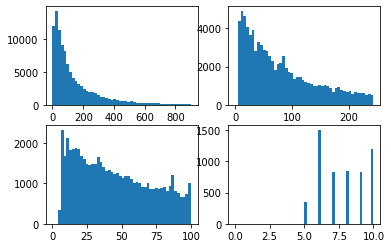

In [ ]:
figure, axis=plt.subplots(2,2)
axis[0,0].hist(lengths, bins=50, range=[0,900])
axis[0,1].hist(lengths, bins=50, range=[0,243])
axis[1,0].hist(lengths, bins=50, range=[0,100])
axis[1,1].hist(lengths, bins=50, range=[0,10])
plt.show()

# Train new model


In [ ]:
from_checkpoint = False #@param{type:"boolean"}

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

training_args = TrainingArguments(
      output_dir='model',
      overwrite_output_dir=True,
      num_train_epochs=1,
      per_device_train_batch_size=64,
      prediction_loss_only=False
  )

model_config=GPT2Config(
      vocab_size= tokenizer.vocab_size,
      pad_token_id=tokenizer.pad_token_id,
      n_ctx=1024,
      n_positions=1024,
      n_head=12,
      n_layer=12,
      n_embd=768
  )

model= GPT2LMHeadModel(model_config)

trainer= Trainer(
      model=model,
      args=training_args,
      data_collator=data_collator,
      train_dataset=tokenized_datasets['train']
  )


if not from_checkpoint:
  
  trainer.train()
  

else:
  checkpoint_path=""#@param{type:"string"}
  trainer.train(checkpoint_path)

tokenizer.save_pretrained('model')
model.save_pretrained('model')

!zip -r my_model2.zip finetuned-gpt2
!cp my_model2.zip /content/drive/MyDrive/my_model_gpt_16.zip
  

NameError: ignored

#Fine-tune Model

In [2]:
from transformers import AutoTokenizer

sequence_length=450 #@param {type:"integer"}
model_name="gpt2" #@param ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]

def tokenize_function(example):
  tokenized_example = tokenizer(
      example['text'],
      truncation=True,
      padding=True,
  )

  return{
      'input_ids': tokenized_example['input_ids']
  }

raw_datasets = load_dataset('text', data_files=[f'email_bodies/{i}' for i in os.listdir('email_bodies')], sample_by='document')
tokenizer=AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
new_tokens = ["[LINK]", "[URL]", "[ATTACHMENT]", "[WORD]", "[POWERPOINT]", "[EXCEL]", "[PDF]"]

# check if the tokens are already in the vocabulary
new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())

# add the tokens to the tokenizer vocabulary
tokenizer.add_tokens(list(new_tokens))
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=raw_datasets['train'].column_names
)

print(tokenized_datasets['train'][0])



Resolving data files:   0%|          | 0/16249 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

{'input_ids': [32, 15438, 284, 3387, 3758, 502, 262, 5505, 88, 393, 257, 4538, 286, 976, 287, 1502, 326, 314, 220, 198, 11261, 3758, 340, 1863, 351, 262, 4538, 286, 262, 5599, 284, 370, 291, 273, 13, 220, 220, 554, 3090, 11, 220, 198, 29688, 2423, 262, 20582, 13444, 287, 262, 4381, 290, 18595, 611, 345, 423, 597, 220, 198, 36653, 13, 198, 198, 9690, 0, 628, 198, 16587, 430, 2448, 1359, 13235, 198, 4834, 1313, 2258, 2253, 11421, 13, 198, 1415, 405, 4176, 3530, 11, 43374, 43550, 20, 198, 33387, 11, 3936, 8541, 21601, 198, 67, 525, 2815, 31, 268, 1313, 13, 785, 198, 6132, 767, 1485, 12, 23, 4310, 12, 29143, 23, 198, 46512, 220, 767, 1485, 12, 27720, 12, 2682, 3829, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 50264, 

In [ ]:
from transformers import AutoModelWithLMHead

n_epochs=10 #@param {type:"integer"}
batch_size=8 #@param {type:"integer"}

model = AutoModelWithLMHead.from_pretrained(model_name)

# add new, random embeddings for the new tokens

model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(
    output_dir=f"./finetuned-{model_name}", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=n_epochs, # number of training epochs
    per_device_train_batch_size=batch_size, # batch size for training
    eval_steps = 250, # Number of update steps between two evaluations.
    save_steps=5000, # after # steps model is saved
    prediction_loss_only=False,
    group_by_length=True
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets['train'],
)

train_results=trainer.train()
tokenizer.save_pretrained(f'./finetuned-{model_name}')
model.save_pretrained(f"./finetuned-{model_name}")
metrics=train_results.metrics
trainer.save_metrics("train", metrics)


/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:1177: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16249
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20320
  Number of trainable parameters = 124445952
You're using a GPT2To

Step,Training Loss
500,3.868800
1000,2.762500
1500,2.585400
2000,2.483200
2500,2.295800
3000,2.281700
3500,2.175200
4000,2.159500
4500,2.029900
5000,2.026800


Saving model checkpoint to ./finetuned-gpt2/checkpoint-5000
Configuration saved in ./finetuned-gpt2/checkpoint-5000/config.json
Model weights saved in ./finetuned-gpt2/checkpoint-5000/pytorch_model.bin
Saving model checkpoint to ./finetuned-gpt2/checkpoint-10000
Configuration saved in ./finetuned-gpt2/checkpoint-10000/config.json
Model weights saved in ./finetuned-gpt2/checkpoint-10000/pytorch_model.bin
Saving model checkpoint to ./finetuned-gpt2/checkpoint-15000
Configuration saved in ./finetuned-gpt2/checkpoint-15000/config.json
Model weights saved in ./finetuned-gpt2/checkpoint-15000/pytorch_model.bin


In [ ]:
Prompt = "[LINK]" #@param {type:"string"}
max_length = 150 #@param {type:"integer"}
temperature = 0.9 #@param {type:"number"}
# Encode the conditioning tokens.

input_ids = tokenizer.encode(Prompt, return_tensors="pt").cuda()
print(input_ids)

# Generate more tokens.

generated_ids = model.generate(
    input_ids,
    max_length=max_length,
    do_sample=True,
    temperature=temperature,
    pad_token_id=50264

)
generated_sequence = tokenizer.decode(generated_ids[0])
print(generated_sequence)

# Inference

# Save Model to Drive


In [ ]:
!zip -r my_model2.zip finetuned-gpt2
!cp my_model2.zip /content/drive/MyDrive/my_model_gpt_21.zip

  adding: finetuned-gpt2/ (stored 0%)
  adding: finetuned-gpt2/tokenizer.json (deflated 72%)
  adding: finetuned-gpt2/checkpoint-10000/ (stored 0%)
  adding: finetuned-gpt2/checkpoint-10000/trainer_state.json (deflated 76%)
  adding: finetuned-gpt2/checkpoint-10000/pytorch_model.bin (deflated 9%)
  adding: finetuned-gpt2/checkpoint-10000/scheduler.pt (deflated 49%)
  adding: finetuned-gpt2/checkpoint-10000/training_args.bin (deflated 48%)
  adding: finetuned-gpt2/checkpoint-10000/rng_state.pth (deflated 28%)
  adding: finetuned-gpt2/checkpoint-10000/optimizer.pt (deflated 8%)
  adding: finetuned-gpt2/checkpoint-10000/config.json (deflated 51%)
  adding: finetuned-gpt2/tokenizer_config.json (deflated 41%)
  adding: finetuned-gpt2/train_results.json (deflated 37%)
  adding: finetuned-gpt2/checkpoint-15000/ (stored 0%)
  adding: finetuned-gpt2/checkpoint-15000/trainer_state.json (deflated 78%)
  adding: finetuned-gpt2/checkpoint-15000/pytorch_model.bin (deflated 9%)
  adding: finetuned-gp

In [ ]:
!rm -r finetuned-gpt2/